# Relief-OpS Workshop: Day-2

In this session, we will working on some examples to solve optimization problems using python. Below are the required packages to run this notebook document.

In [1]:
from mip import *
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon
import math

The required packages are listed above. If you would like to save this document and run it somewhere else, please make sure to install the required packages.

## Optimization Problem

As an example, we will take a look at the works given by Perdana et al. (2021):

- Sets
    - $I$: set of consumer base regions
    - $J$: set of optional Regional Food Hub (RFH) locations
    - $K$: set of producer areas
    - $C$: set of commodities

- Parameters
    - $d_{ci}$: demand of commodity $c$ in consumer base region $i$ (kilotonne/day)
    - $f_{ck}$: production capacity of commodity $c$ in producer area $k$ (kilotonne/day)
    - $v_{ci}$: selling price of commodity $c$ in consumer base region $i$ (Rp/kilotonne)
    - $b_{ji}$: distribution cost between region $j$ and region $i$ for transporting the food (Rp/kilotonne)
    - $q$: handling cost (Rp/kilotonne)
    - $h$: RFH development cost (Rp/unit)

- Decision variables
    - $x_j$: decides if the RFH will be built on region $j$ or not $(x_j\in\{0,1\})$
    - $P_{cj}$: capacity of commodity $c$ which stored in RFH built at region $j$ $(P_{cj}\in\mathbb{R})$
    - $y_{ckj}$: ratio of commodity production $c$ produced on region $k$ sent to the RFH at region $j$ (proportional to production capacity $f_{ck}$) ($y_{ckj}\in[0,1]$)
    - $w_{cji}$: ratio of commodity demand $c$ on region $i$ fulfilled by the RFH at region $j$ (proportional to demand $d_{ci}$) $(w_{cji}\in\mathbb{R})$
    
- Optimization model

\begin{equation}
\max\left\{\sum_{c\in C}\sum_{i\in I}v_{ci}\sum_{j\in J}w_{cji}\right\},
\label{max}
\end{equation}

\begin{equation}
\min\left\{h\sum_{j \in J}x_j+q\sum_{c\in C}\sum_{j\in J}P_{cj}+\sum_{c\in C}\sum_{j\in J}\sum_{i\in I}b_{ji}d_{ci}w_{cji}+\sum_{c\in C}\sum_{k\in K}\sum_{j\in J}b_{kj}f_{ck}y_{ckj}\right\},
\label{min}
\end{equation}

\begin{equation}
\begin{gathered}
\sum_{k\in K}f_{ck}y_{ckj}=P_{cj},\forall c\in C,j\in J,\\
\sum_{i\in I}d_{ci}w_{cji}=P_{cj},\forall c\in C,j\in J,
\end{gathered}
\label{eq5}
\end{equation}

\begin{equation}
\sum_{j\in J}y_{ckj}\le1,\forall c\in C,k\in K,
\label{eq6}
\end{equation}

\begin{equation}
\sum_{j\in J}w_{cji}\le1,\forall c\in C,i\in I,
\label{eq7}
\end{equation}

\begin{equation}
y_{ckj}\le x_j,\forall c\in C,k\in K,j\in J,
\label{eq8}
\end{equation}

\begin{equation}
w_{cji}\le x_j,\forall c\in C,j\in J,i \in I,
\label{eq9}
\end{equation}

## Optimization in Python

To solve the optimization problem in python, we need to create an object which later contains our optimization model. In this case, we give it a name "model1".

In [2]:
model1=Model() # create an optimization object

Once it is created, we are ready to build the optimization model into it. Next, we need to define all of the sets listed on the optimization model:

In [3]:
# Sets

I=list(range(27)) # set of consumer base regions
J=list(range(27)) # set of optional RFH locations
K=list(range(27)) # set of producer areas
C=list(range(3)) # set of commodities (rice,chicken eggs,vegetables)

Then, we need to define all of the parameters on the optimization models. In this case, the input parameters and data are available locally through a repository. The only thing to do is import the excel file and give it a name related to the parameters needed.

In [4]:
# Parameters

d=pd.read_excel(r'Demand.xlsx',header=0,usecols="B:AB",nrows=3) # demand parameters
d=d.to_numpy() # convert dataframe to array

v=pd.read_excel(r'Selling Price.xlsx',header=0,usecols="B:AB",nrows=3) # selling price parameters
v=v.to_numpy()

f=pd.read_excel(r'Production.xlsx',header=0,usecols="B:AB",nrows=3) # production capacity parameters
f=f.to_numpy()

b=pd.read_excel(r'Distribution Cost.xlsx',header=0,usecols="B:AB",nrows=27) # distribution cost parameters
b=b.to_numpy()

q= 5198 # handling cost parameter

h= 200000/(30*360) # RFH development cost parameter

We also need to define all decision variables in the optimization model:

In [5]:
# Decision variables
x=[model1.add_var(var_type=BINARY) for j in J]
P=[[model1.add_var(var_type=CONTINUOUS,lb=0) for j in J] for c in C]
y=[[[model1.add_var(var_type=CONTINUOUS,lb=0,ub=1) for j in J] for k in K] for c in C]
w=[[[model1.add_var(var_type=CONTINUOUS,lb=0,ub=1) for i in I] for j in J] for c in C]

Hereinafter, we are ready to construct the objective and constraint functions. Since we are dealing with multiobjective optimization problems, we need to decide the method to solve the problem. For the first trial, we will use Weighted Sum Method. 

# Method #1: Weighted Sum Method

In Weighted Sum Method, we need to define an appropriate weight for each of the objective function which describe their priority. In this problem, our first priority objective function  is:

\begin{equation}
\max\left\{\sum_{c\in C}\sum_{i\in I}v_{ci}\sum_{j\in J}w_{cji}\right\}.
\label{max}
\end{equation}
which maximize the food demand fulfillment. Meanwhile, the second priority objective function is:
\begin{equation}
\min\left\{h\sum_{j \in J}x_j+q\sum_{c\in C}\sum_{j\in J}P_{cj}+\sum_{c\in C}\sum_{j\in J}\sum_{i\in I}b_{ji}d_{ci}w_{cji}+\sum_{c\in C}\sum_{k\in K}\sum_{j\in J}b_{kj}f_{ck}y_{ckj}\right\},
\label{min}
\end{equation}

which minimize the total operational costs (RFH development cost, food handling cost, distribution cost).

One "trick" is by letting the weight of the second objective is 1. Then, for the weight of the first objective, we need to set it higher than any of the coefficients involved in the second objective. In other words, we need to find the highest number between $h$, $q$, $b_{ji}d_{ci}$ (for all $c,i,j$), and $b_{kj}f_{ck}$ (for all $c,k,j$) as given below:

In [6]:
max(h,np.amax(b)*np.amax(d),q,np.amax(b)*np.amax(f))

5198

Then, we set the weight of the first objective to any number higher than 5198. For this example, let's round it to thousands:

In [7]:
np.ceil(max(h,np.amax(b)*np.amax(d),q,np.amax(b)*np.amax(f))/(1000))*1000

6000.0

Thus, we obtained a single weighted objective function:
\begin{equation}
\max\left\{6000\cdot\left(\sum_{c\in C}\sum_{i\in I}v_{ci}\sum_{j\in J}w_{cji}\right)-\left(h\sum_{j \in J}x_j+q\sum_{c\in C}\sum_{j\in J}P_{cj}+\sum_{c\in C}\sum_{j\in J}\sum_{i\in I}b_{ji}d_{ci}w_{cji}+\sum_{c\in C}\sum_{k\in K}\sum_{j\in J}b_{kj}f_{ck}y_{ckj}\right)\right\}.
\label{max}
\end{equation}

Then, set the above objective function into python optimization object "model1" which we defined earlier:

In [8]:
# set objective

model1.objective = maximize(6000*xsum(v[c][i]*w[c][j][i] for c in C for j in J for i in I) - xsum(h*x[j] for j in J) - xsum(q*P[c][j] for c in C for j in J) - xsum(b[j][i]*d[c][i]*w[c][j][i] for c in C for j in J for i in I) - xsum(b[k][j]*f[c][k]*y[c][k][j] for c in C for k in K for j in J))

Afterwards, we set all of the constraint functions into the "model1" object:

In [9]:
# set constraints
for c in C:
    for j in J:
        model1 += xsum(f[c][k]*y[c][k][j] for k in K)==P[c][j]

for c in C:
    for j in J:
        model1 += xsum(d[c][i]*w[c][j][i] for i in I)==P[c][j] 

for c in C:
    for k in K:
        model1 += xsum(y[c][k][j] for j in J)<=1
        
for c in C:
    for i in I:
        model1 += xsum(w[c][j][i] for j in J)<=1

for c in C:
    for k in K:
        for j in J:
            model1 += y[c][k][j]<=x[j]
            
for c in C:
    for j in J:
        for i in I:
            model1 += w[c][j][i]<=x[j]

Once all of the components settled, then we can solve the optimization object "model1"

In [10]:
# solve the model
model1.optimize()

<OptimizationStatus.OPTIMAL: 0>

We finally solved the optimization problem with optimum result. We can check the obtained value of objective function through:

In [11]:
# return the objective value
model1.objective_value

8073986316.196317

Then, we also need to check the optimum solution of the decision variables. For an example, to obtain the optimum solution of $x_j$, we can run:

In [12]:
# return the x solution
for j in J:
    print("x[{}]:{}".format(j, x[j].x))

x[0]:1.0
x[1]:0.0
x[2]:0.0
x[3]:0.0
x[4]:1.0
x[5]:0.0
x[6]:0.0
x[7]:0.0
x[8]:0.0
x[9]:0.0
x[10]:0.0
x[11]:0.0
x[12]:0.0
x[13]:0.0
x[14]:0.0
x[15]:1.0
x[16]:1.0
x[17]:1.0
x[18]:0.0
x[19]:0.0
x[20]:0.0
x[21]:0.0
x[22]:0.0
x[23]:0.0
x[24]:1.0
x[25]:0.0
x[26]:0.0


Hereafter, we will try the second method for multiobjective optimization problem: Lexicographic Method.

# Method #2: Lexicographic Method

In Lexicographic Method, we do not need to define an appropriate weight for each of the objective function. Instead, we are solving the problem for each of the objective function iteratively from the first priority objective function down to the last objective. Therefore, we still need to set their priority. In this problem, our first priority objective function  is:

\begin{equation}
\max\left\{\sum_{c\in C}\sum_{i\in I}v_{ci}\sum_{j\in J}w_{cji}\right\}.
\label{max}
\end{equation}

which maximize the food demand fulfillment. Meanwhile, the second priority objective function is:

\begin{equation}
\min\left\{h\sum_{j \in J}x_j+q\sum_{c\in C}\sum_{j\in J}P_{cj}+\sum_{c\in C}\sum_{j\in J}\sum_{i\in I}b_{ji}d_{ci}w_{cji}+\sum_{c\in C}\sum_{k\in K}\sum_{j\in J}b_{kj}f_{ck}y_{ckj}\right\},
\label{min}
\end{equation}

which minimize the total operational costs (RFH development cost, food handling cost, distribution cost).

For the first iteration, we solve the optimization problem only with the first objective function and keep the second objective aside. In other words, for the first iteration, we are solving the following problem:

\begin{equation}
\max\left\{\sum_{c\in C}\sum_{i\in I}v_{ci}\sum_{j\in J}w_{cji}\right\},
\end{equation}

\begin{equation}
\begin{gathered}
\sum_{k\in K}f_{ck}y_{ckj}=P_{cj},\forall c\in C,j\in J,\\
\sum_{i\in I}d_{ci}w_{cji}=P_{cj},\forall c\in C,j\in J,
\end{gathered}
\label{eq5}
\end{equation}

\begin{equation}
\sum_{j\in J}y_{ckj}\le1,\forall c\in C,k\in K,
\label{eq6}
\end{equation}

\begin{equation}
\sum_{j\in J}w_{cji}\le1,\forall c\in C,i\in I,
\label{eq7}
\end{equation}

\begin{equation}
y_{ckj}\le x_j,\forall c\in C,k\in K,j\in J,
\label{eq8}
\end{equation}

\begin{equation}
w_{cji}\le x_j,\forall c\in C,j\in J,i \in I,
\label{eq9}
\end{equation}

Now, let's create another optimization object in python called "model2" for the first iteration:

In [13]:
model2=Model()

Since we are still using the same sets and parameters, we do not need to reinput them. Nevertheless, we need to use other object for the decision variables in this method (since the previous decision variables has been stored with the optimum solution via Weight Sum Method).

In [14]:
# Decision variables
x2=[model2.add_var(var_type=BINARY) for j in J]
P2=[[model2.add_var(var_type=CONTINUOUS,lb=0) for j in J] for c in C]
y2=[[[model2.add_var(var_type=CONTINUOUS,lb=0,ub=1) for j in J] for k in K] for c in C]
w2=[[[model2.add_var(var_type=CONTINUOUS,lb=0,ub=1) for i in I] for j in J] for c in C]

Then, we need to define the objective and constraint functions:

In [15]:
# set objective

model2.objective = maximize(xsum(v[c][i]*w2[c][j][i] for c in C for j in J for i in I))

# set constraints
for c in C:
    for j in J:
        model2 += xsum(f[c][k]*y2[c][k][j] for k in K)==P2[c][j]

for c in C:
    for j in J:
        model2 += xsum(d[c][i]*w2[c][j][i] for i in I)==P2[c][j] 

for c in C:
    for k in K:
        model2 += xsum(y2[c][k][j] for j in J)<=1
        
for c in C:
    for i in I:
        model2 += xsum(w2[c][j][i] for j in J)<=1

for c in C:
    for k in K:
        for j in J:
            model2 += y2[c][k][j]<=x[j]
            
for c in C:
    for j in J:
        for i in I:
            model2 += w2[c][j][i]<=x[j]

Once the optimization problem for the first iteration is settled, solve it:

In [16]:
model2.optimize()

<OptimizationStatus.OPTIMAL: 0>

The optimum solution is found, with the objective function:

In [17]:
model2.objective_value

1345678.630705194

After the first iteration finished, the optimum objective function of the first iteration is going to be used in the second iteration as the new constraint function. Since the preceeding objective function is "maximization", then the first objective will be used in the second iteration as the lower bound constraint:

$$\sum_{c\in C}\sum_{i\in I}v_{ci}\sum_{j\in J}w_{cji}\ge1345678.630705194$$

Thus, for the second iteration, the optimization problem is given as:

\begin{equation}
\min\left\{h\sum_{j \in J}x_j+q\sum_{c\in C}\sum_{j\in J}P_{cj}+\sum_{c\in C}\sum_{j\in J}\sum_{i\in I}b_{ji}d_{ci}w_{cji}+\sum_{c\in C}\sum_{k\in K}\sum_{j\in J}b_{kj}f_{ck}y_{ckj}\right\},
\label{min}
\end{equation}

\begin{equation}
\begin{gathered}
\sum_{k\in K}f_{ck}y_{ckj}=P_{cj},\forall c\in C,j\in J,\\
\sum_{i\in I}d_{ci}w_{cji}=P_{cj},\forall c\in C,j\in J,
\end{gathered}
\label{eq5}
\end{equation}

\begin{equation}
\sum_{j\in J}y_{ckj}\le1,\forall c\in C,k\in K,
\label{eq6}
\end{equation}

\begin{equation}
\sum_{j\in J}w_{cji}\le1,\forall c\in C,i\in I,
\label{eq7}
\end{equation}

\begin{equation}
y_{ckj}\le x_j,\forall c\in C,k\in K,j\in J,
\label{eq8}
\end{equation}

\begin{equation}
w_{cji}\le x_j,\forall c\in C,j\in J,i \in I,
\label{eq9}
\end{equation}

$$\sum_{c\in C}\sum_{i\in I}v_{ci}\sum_{j\in J}w_{cji}\ge1345678.630705194$$

Now, let's create another optimization object in python for the second iteration, namely "model3":

In [18]:
model3=Model()

Similar to the first iteration, we do not need to reinput the sets and parameters. Nonetheless, we need to use other object for the decision variables in this second iteration:

In [19]:
# Decision variables
x3=[model3.add_var(var_type=BINARY) for j in J]
P3=[[model3.add_var(var_type=CONTINUOUS,lb=0) for j in J] for c in C]
y3=[[[model3.add_var(var_type=CONTINUOUS,lb=0,ub=1) for j in J] for k in K] for c in C]
w3=[[[model3.add_var(var_type=CONTINUOUS,lb=0,ub=1) for i in I] for j in J] for c in C]

Then, we need to define the objective and constraint functions:

In [20]:
# set objective

model3.objective = minimize(xsum(h*x3[j] for j in J) + xsum(q*P3[c][j] for c in C for j in J) + xsum(b[j][i]*d[c][i]*w3[c][j][i] for c in C for j in J for i in I) + xsum(b[k][j]*f[c][k]*y3[c][k][j] for c in C for k in K for j in J))

# set constraints
for c in C:
    for j in J:
        model3 += xsum(f[c][k]*y3[c][k][j] for k in K)==P3[c][j]

for c in C:
    for j in J:
        model3 += xsum(d[c][i]*w3[c][j][i] for i in I)==P3[c][j] 

for c in C:
    for k in K:
        model3 += xsum(y3[c][k][j] for j in J)<=1
        
for c in C:
    for i in I:
        model3 += xsum(w3[c][j][i] for j in J)<=1

for c in C:
    for k in K:
        for j in J:
            model3 += y3[c][k][j]<=x[j]
            
for c in C:
    for j in J:
        for i in I:
            model3 += w3[c][j][i]<=x[j]
            
model3 += xsum(v[c][i]*w2[c][j][i] for c in C for j in J for i in I)>=model2.objective_value

Once the optimization problem for the second iteration is settled, solve it:

In [21]:
model3.optimize()

<OptimizationStatus.OPTIMAL: 0>

The optimum solution is found, with the objective function:

In [22]:
model3.objective_value

85468.03476887656

After the second iteration is done, we already solved the optimization problem using Lexicographic Method. The optimum result and solutions via Lexicographic Method are based on the last iteration.

To check whether the Weighted Sum Method and Lexicographic Method give the same result, one can compare the objective values obtained between the two methods.

In [23]:
print("Objective Values via Weighted Sum Method\t:{}".format(model1.objective_value))
print("Objective Values via Lexicographic Method\t:{}".format(6000*model2.objective_value-model3.objective_value))

Objective Values via Weighted Sum Method	:8073986316.196317
Objective Values via Lexicographic Method	:8073986316.196396


As given above, there is a slight difference from the 15th place. There will always be a slight difference/error since the precision in computation has its own limit. As an illustration, we will try to evaluate $f(x)=(x-1)^3$ in two different ways:
$$g(x)=(x-1)^3,$$
and
$$h(x)=x^3-3x^2+3x-1.$$

One can easily verify that $g(x)=h(x)$. Then, we will try to evaluate both functions in the same interval $[0.99998,1.00002]$

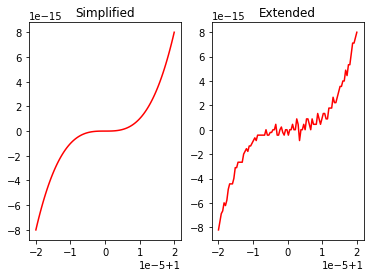

In [24]:
# 100 linearly spaced numbers in interval [0.99998,1.00002]
x_axis = np.linspace(0.99998,1.00002,100)

# the function, which is y = (x-1)^3
y_value = (x_axis - 1)**3

fig1 = plt.subplot(1,2,1)
fig1.set_title("Simplified")

# plot the function
plt.plot(x_axis,y_value, 'r')

# other form of the same function
y_value2 = x_axis**3 - 3*x_axis**2 + 3*x_axis - 1

fig2 = plt.subplot(1,2,2)
fig2.set_title("Extended")

# plot the function
plt.plot(x_axis,y_value2, 'r')

# show the plot
plt.show()

As given in the above evaluation, the more complex the calculation, the more error is produced. Hence, we can ignore the small amount of differences since there will always be an $\epsilon$ error and proceed to the optimization problem.

In the previous section, we already obtained the optimum solution of $x_j$:

In [25]:
# return the x solution
for j in J:
    print("x[{}]:{}".format(j, x[j].x))

x[0]:1.0
x[1]:0.0
x[2]:0.0
x[3]:0.0
x[4]:1.0
x[5]:0.0
x[6]:0.0
x[7]:0.0
x[8]:0.0
x[9]:0.0
x[10]:0.0
x[11]:0.0
x[12]:0.0
x[13]:0.0
x[14]:0.0
x[15]:1.0
x[16]:1.0
x[17]:1.0
x[18]:0.0
x[19]:0.0
x[20]:0.0
x[21]:0.0
x[22]:0.0
x[23]:0.0
x[24]:1.0
x[25]:0.0
x[26]:0.0


Once the mathematical solution is obtained, the next step to do is interpret all of the results into valuable information, which covered in the next section.

### Interpret The Results #1: RFHs Location

Although we already have all of the values of $x_j$ for all index, but it still doesn't give us the valuable result. Hence, we need to represent the result into more valuable meanings. In this time, we will try to interpret the optimum RFHs location. Recall that the decision variables $x_j$ represents whether RFH is built in region $j$ or not. Then, we have to call the name of all regions within the set $J$ and match it with the $x_j$ value.

In [26]:
regions=pd.read_excel(r'Demand.xlsx',header=0,usecols="B:AB",nrows=0) # input the column names from demand data
regions=list(regions.columns) # take only the column names (which exactly what we need: region names)

To get the valuable information of where the RFHs should be build from the optimization result, we can run:

In [27]:
rfh_index=[a for a in range(len(regions)) if x[a].x==1] # get the index of RFH locations

info1=[0]*len(rfh_index) # creating an empty list

header=["Optimum RFH Location"] # create the header

for i in range(len(rfh_index)):
    info1[i]=["{}".format(regions[rfh_index[i]])] # list the selected regions for RFH

print(tabulate(info1,header,tablefmt="fancy_grid"))

╒════════════════════════╕
│ Optimum RFH Location   │
╞════════════════════════╡
│ Ciamis Regency         │
├────────────────────────┤
│ Cirebon Regency        │
├────────────────────────┤
│ Bogor Regency          │
├────────────────────────┤
│ Cianjur Regency        │
├────────────────────────┤
│ Bandung Regency        │
├────────────────────────┤
│ Karawang Regency       │
╘════════════════════════╛


Now, let's take the RFHs capacity into account. Recall the definition of decision variables $P_{cj}$.

In [28]:
info2=[[0]]*len(rfh_index)

header2=["Optimum RFH Location","Rice Cap. (tonne/day)","Eggs Cap. (tonne/day)","Vegetables Cap. (tonne/day)"]

for i in range(len(rfh_index)):
    info2[i]="{}".format(regions[rfh_index[i]]),"{}".format(P[0][rfh_index[i]].x*1000),"{}".format(P[1][rfh_index[i]].x*1000),"{}".format(P[2][rfh_index[i]].x*1000)
    
print(tabulate(info2,header2,tablefmt="fancy_grid"))

╒════════════════════════╤═════════════════════════╤═════════════════════════╤═══════════════════════════════╕
│ Optimum RFH Location   │   Rice Cap. (tonne/day) │   Eggs Cap. (tonne/day) │   Vegetables Cap. (tonne/day) │
╞════════════════════════╪═════════════════════════╪═════════════════════════╪═══════════════════════════════╡
│ Ciamis Regency         │                 1908.81 │                122.807  │                       598.829 │
├────────────────────────┼─────────────────────────┼─────────────────────────┼───────────────────────────────┤
│ Cirebon Regency        │                 1748.59 │                138.116  │                       317.906 │
├────────────────────────┼─────────────────────────┼─────────────────────────┼───────────────────────────────┤
│ Bogor Regency          │                 1713.57 │                167.649  │                       293.711 │
├────────────────────────┼─────────────────────────┼─────────────────────────┼───────────────────────────────┤
│

### Interpret The Results #2: Demand Fulfillment

Next, we will try to interpret the demand fulfillment of all regions. Recall the decision variable $w_{cji}$ which represents fulfillment ratio of commodity $c$ in region $i$ by RFH in region $j$. The fulfillment ratio of commodity $c$ in each region $i$ could be calculated as:

$$\sum_{j\in J}w_{cji},\;\;\;\;\;\;\;\;\forall c\in C,i\in I$$

Based on the above formula, we can calculate the demand fulfillment as:

In [29]:
tmp_w=np.empty(shape=(len(C),len(J),len(I))) # create empty array for variable w[c,j,i]
tmp_w[:]=0 # fill array with 0
for c in C:
    for j in J:
        for i in I:
            tmp_w[c,j,i]=w[c][j][i].x   # store w[c,j,i] value
            
            
ful=np.empty(shape=(len(I),len(C))) # create empty array for demand fulfillment for each consumer base
ful[:]=0 # fill array with 0

for i in I:
    for c in C:
        ful[i,c]=round(sum(tmp_w[c,:,i]),12) # calculate demand fulfillment for each consumer base
        
info3=[[0]]*len(I)

header3=["Consumer Base","Rice Demand Fulfilled (%)","Eggs Demand Fulfilled (%)","Vegetables Demand Fulfilled (%)"]

for i in range(len(I)):
    info3[i]="{}".format(regions[i]),"{}".format(ful[i,0]*100),"{}".format(ful[i,1]*100),"{}".format(ful[i,2]*100)
    
print(tabulate(info3,header3,tablefmt="fancy_grid"))

╒═══════════════════════╤═════════════════════════════╤═════════════════════════════╤═══════════════════════════════════╕
│ Consumer Base         │   Rice Demand Fulfilled (%) │   Eggs Demand Fulfilled (%) │   Vegetables Demand Fulfilled (%) │
╞═══════════════════════╪═════════════════════════════╪═════════════════════════════╪═══════════════════════════════════╡
│ Ciamis Regency        │                         100 │                         100 │                          100      │
├───────────────────────┼─────────────────────────────┼─────────────────────────────┼───────────────────────────────────┤
│ Garut Regency         │                         100 │                         100 │                          100      │
├───────────────────────┼─────────────────────────────┼─────────────────────────────┼───────────────────────────────────┤
│ Tasikmalaya Regency   │                         100 │                         100 │                          100      │
├───────────────────────

As seen from table above, vegetables demand in Bogor Regency could not be completely fulfilled. Although the overall vegetables produced in West Java has been distributed, all of the vegetables produced in West Java is insufficient to fulfill the demand from all regions in West Java as given in the following bar chart.

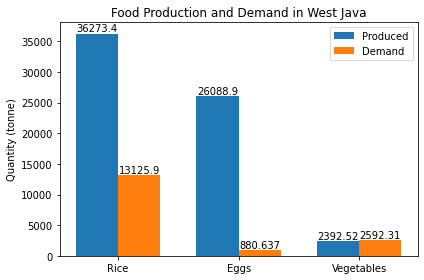

In [30]:
labels = ["Rice","Eggs","Vegetables"]

produced=[sum(f[0,:])*1000,sum(f[1,:])*1000,sum(f[2,:])*1000] # calculate total production capacity for rice, eggs, and vegetables
demand=[sum(d[0,:])*1000,sum(d[1,:])*1000,sum(d[2,:])*1000] # calculate total demand for rice, eggs, and vegetables

x=np.arange(len(labels)) # number of labels

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

# Add some text for labels, title and custom x-axis tick labels, etc.
bar1=ax.bar(x - width/2, produced, width, label='Produced')
bar2=ax.bar(x + width/2, demand, width, label='Demand')
ax.set_ylabel('Quantity (tonne)')
ax.set_title('Food Production and Demand in West Java')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(bar1)
ax.bar_label(bar2)

fig.tight_layout()

plt.show()

### Interpret The Result #3: Food Network

We will try to interpret the food network from the optimization result. In this problem, the food network involves producer area, RFH, and consumer base. The food network between producer areas and RFHs are represented by decision variables $y_{ckj}$. Meanwhile, the food network between RFHs and consumer bases are represented by decision variables $w_{cji}$.

First of all, we need to retrieve the latitude and longitude of every regions in West Java through:

In [31]:
data = {'Region': regions}

loc = pd.DataFrame(data) # create location dataframe

temp_lat=pd.read_excel(r'Location.xlsx',header=0,usecols="B:B",nrows=len(regions)) # import latitude to temporary object
temp_long=pd.read_excel(r'Location.xlsx',header=0,usecols="C:C",nrows=len(regions)) # import longitude to temporary object

loc["lat"]=temp_lat # input the latitude to location dataframe
loc["long"]=temp_long # input longitude to location dataframe

test=[Point(xy) for xy in zip(loc["long"],loc["lat"])] # make points from latitude and longitude of each region

geo_df=gpd.GeoDataFrame(loc["Region"],crs={"init": "epsg:4326"},geometry=test)

geo_df

,Region,geometry
0,Ciamis Regency,POINT (108.40798 -7.28372)
1,Garut Regency,POINT (107.75857 -7.37131)
2,Tasikmalaya Regency,POINT (108.12933 -7.55551)
3,Tasikmalaya City,POINT (108.22950 -7.35076)
4,Cirebon Regency,POINT (108.52001 -6.78559)
5,Cirebon City,POINT (108.54868 -6.73291)
6,Indramayu Regency,POINT (108.21361 -6.39032)
7,Majalengka Regency,POINT (108.28247 -6.81552)
8,Kuningan Regency,POINT (108.56566 -7.00280)
9,Sukabumi Regency,POINT (106.72307 -7.05369)


Now let's plot the points of all regions through:

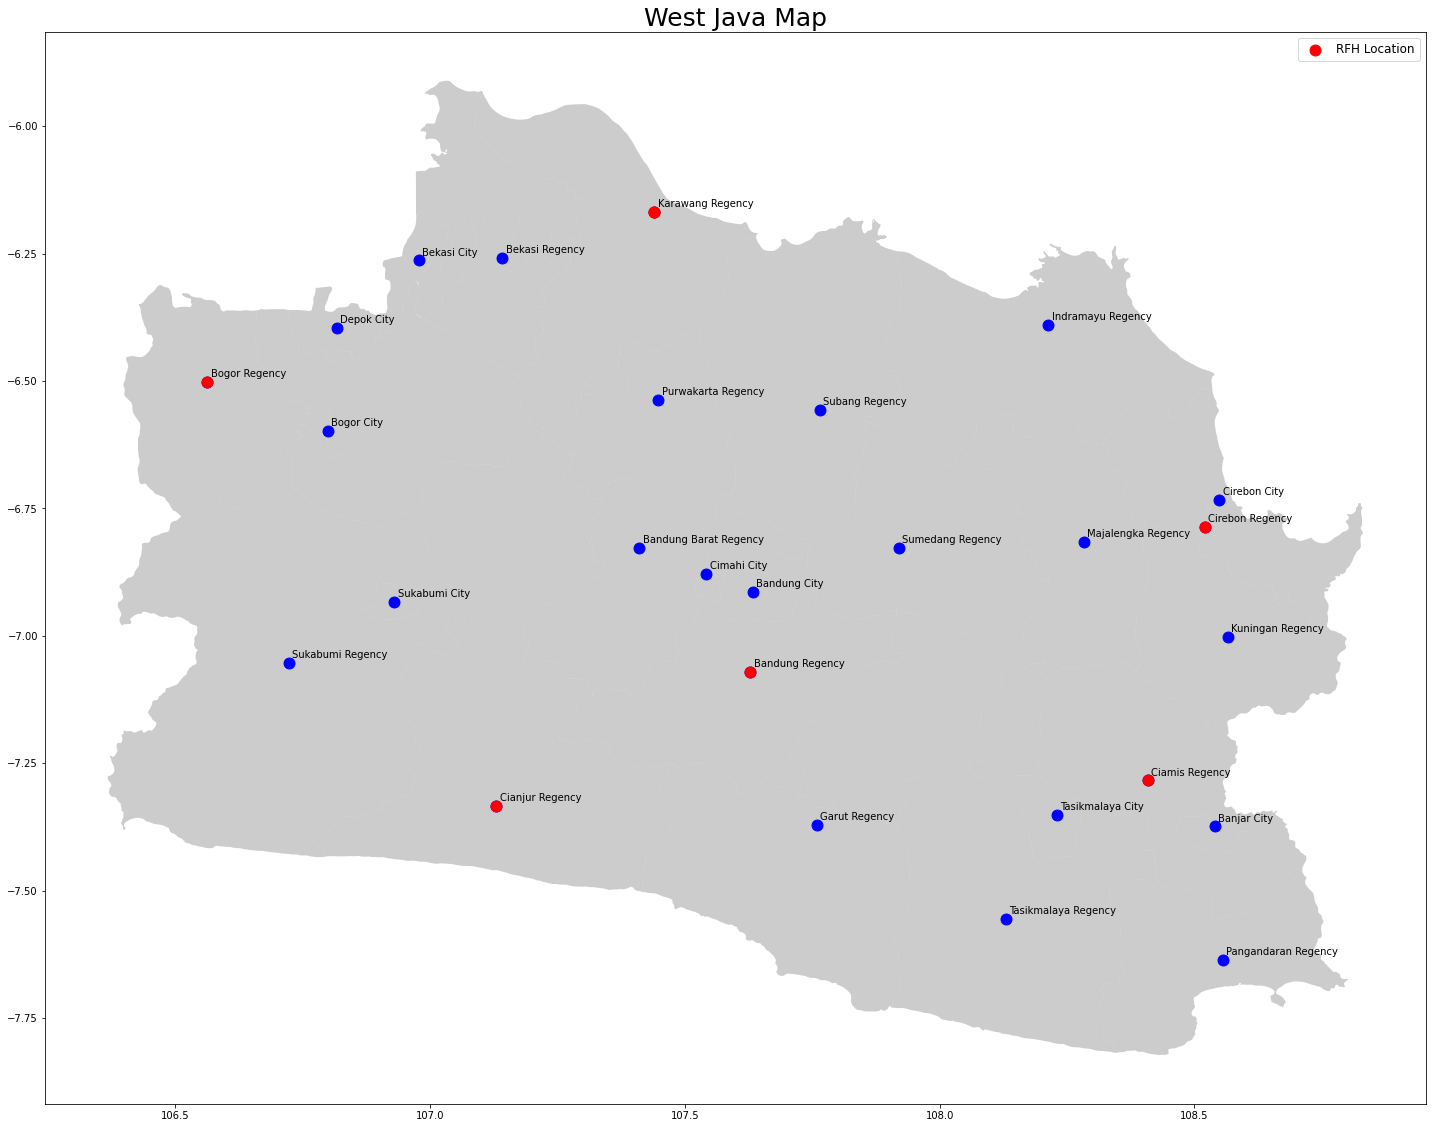

In [32]:
westjava_map=gpd.read_file(r'indexbencana-polygon.shp') # import shapefile GIS data

fig,ax=plt.subplots(figsize=(20,20))
westjava_map.plot(ax=ax,alpha=0.4,color="grey") # plot the GIS shapefile
geo_df.plot(ax=ax,markersize=120,color="blue",marker="o") # plot all the region points

for i in rfh_index:
    geo_df[i:(i+1)].plot(ax=ax,markersize=120,color="red",marker="o") # set red dot as RFH location

geo_df[i:(i+1)].plot(ax=ax,markersize=120,color="red",marker="o",label="RFH Location") # repeat once to add a label
    
for i, label in enumerate(loc["Region"]):
    plt.annotate(label, (loc["long"][i]+0.007, loc["lat"][i]+0.01)) # show the name of each region in the plot
    
ax.set_title('West Java Map',fontsize=25) # set title
ax.legend(prop={'size':12}) # set legend size

fig.tight_layout()
    
plt.show()

Once the latitude and longitude of all regions are retrieved, we can proceed to construct the food network between food producer $k$ and RFH $j$ based on $y_{ckj}$. If there is any food commodity $c$ sent from food producer $k$ to RFH $j$, then food producer $k$ and RFH $j$ are connected. In the similar way, RFH $j$ and consumer base $i$ are connected only if there is any food commodity $c$ sent from RFH $j$ to consumer base $i$.

In [33]:
prod_to_RFH=[(k,j) for  k in K for j in J if y[c][k][j].x>0] # obtain the connectivity index between producer area and RFH
RFH_to_cons=[(j,i) for j in J for i in I if w[c][j][i].x>0] # obtain the connectivity index between RFH and consumer base

Then, we can start plotting the food network. First, let's plot the food network from the producer areas to RFHs:

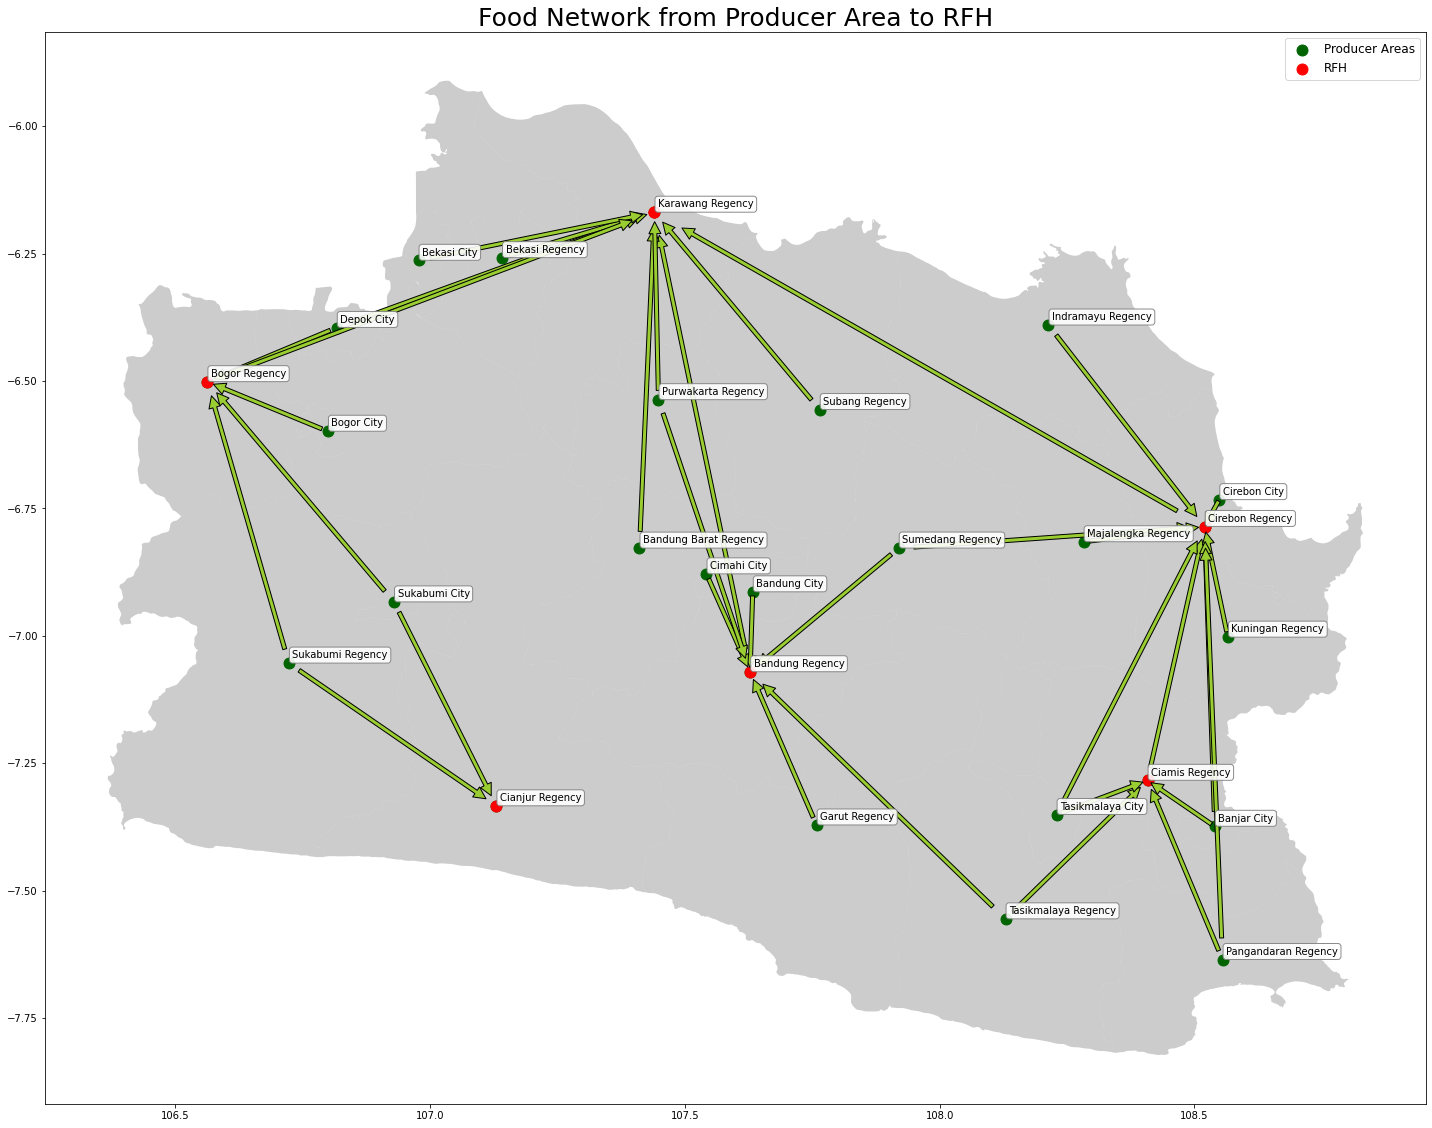

In [34]:
westjava_map=gpd.read_file(r'indexbencana-polygon.shp') # import shapefile GIS data

fig,ax=plt.subplots(figsize=(20,20))
westjava_map.plot(ax=ax,alpha=0.4,color="grey") # plot the GIS shapefile

# plot arrow indicating the network from producer area to RFH
for i in range(len(prod_to_RFH)):
    plt.annotate('',xy=(loc["long"][prod_to_RFH[i][1]],loc["lat"][prod_to_RFH[i][1]]),xytext=(loc["long"][prod_to_RFH[i][0]],loc["lat"][prod_to_RFH[i][0]]),arrowprops=dict(facecolor='yellowgreen', shrink=0.05))

# show the name of all region in plot
for i, label in enumerate(loc["Region"]):
    plt.annotate(label, (loc["long"][i]+0.007, loc["lat"][i]+0.01),bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
    
geo_df.plot(ax=ax,markersize=120,color="darkgreen",marker="o",label="Producer Areas") # plot all producer areas

for i in rfh_index:
    geo_df[i:(i+1)].plot(ax=ax,markersize=120,color="red",marker="o") # set red dot as RFH location
    
geo_df[i:(i+1)].plot(ax=ax,markersize=120,color="red",marker="o",label="RFH") # repeat once to give a label

ax.set_title('Food Network from Producer Area to RFH',fontsize=25) # set titile
ax.legend(prop={'size':12})

fig.tight_layout()
    
plt.show()

Similarly, we can plot the food network between the RFHs and consumer bases through:

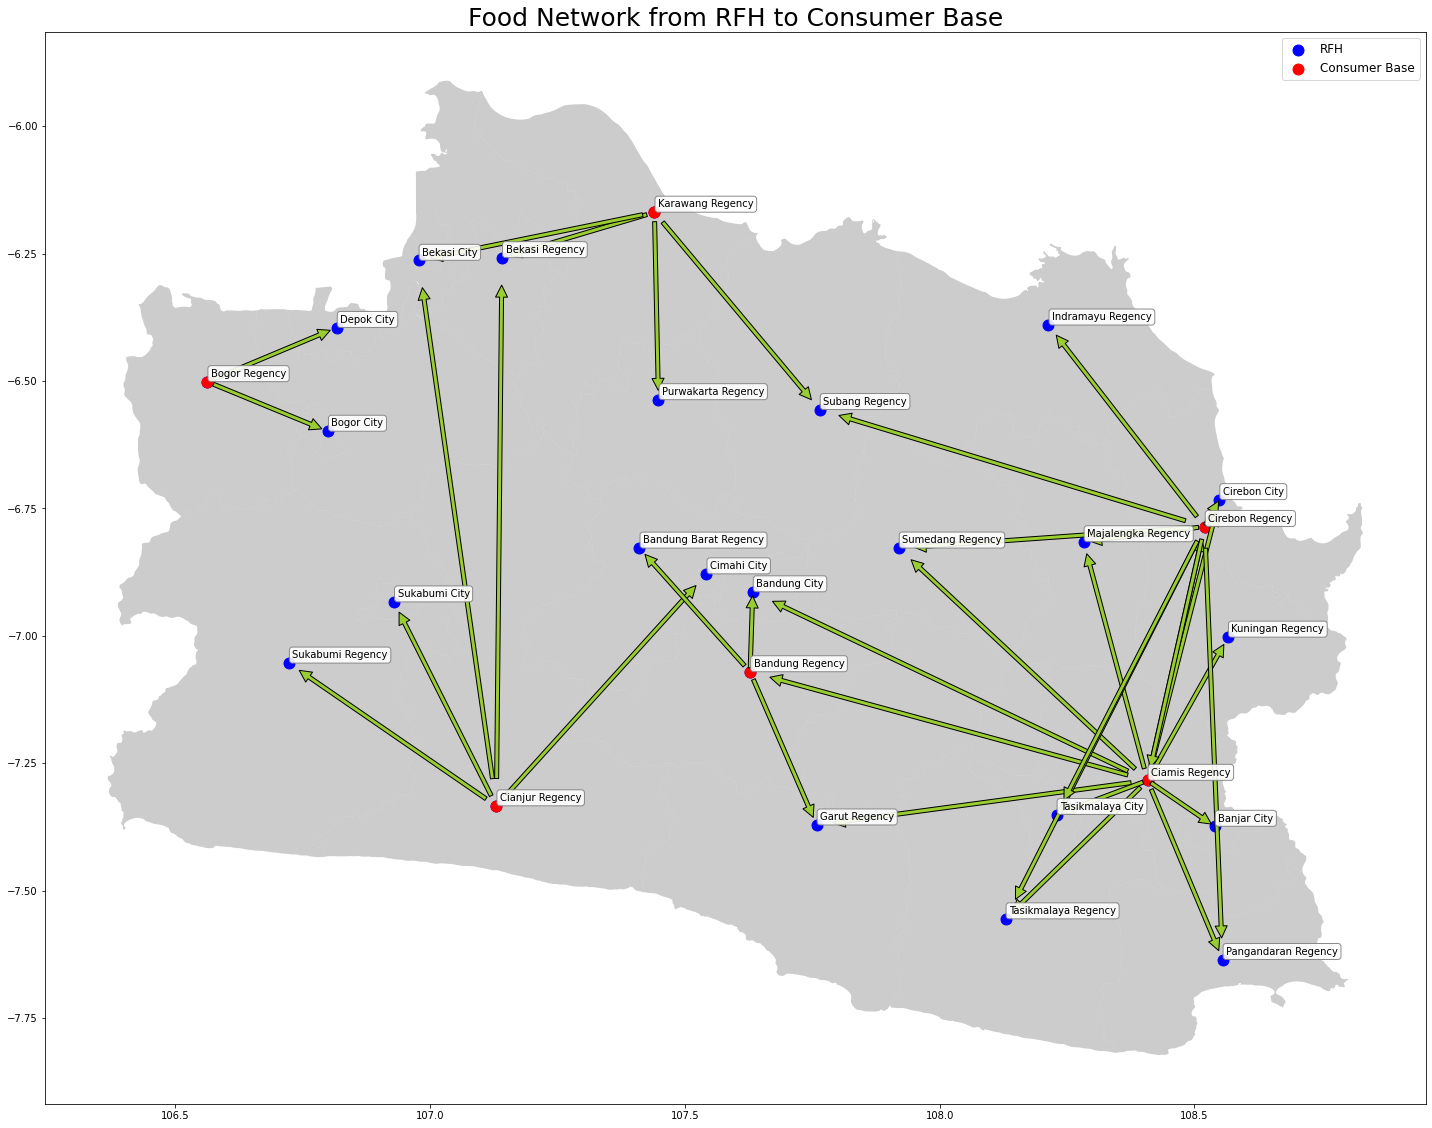

In [35]:
westjava_map=gpd.read_file(r'indexbencana-polygon.shp') # import shapefile GIS data

fig,ax=plt.subplots(figsize=(20,20))
westjava_map.plot(ax=ax,alpha=0.4,color="grey")

for i in range(len(RFH_to_cons)):
    plt.annotate('',xy=(loc["long"][RFH_to_cons[i][1]],loc["lat"][RFH_to_cons[i][1]]),xytext=(loc["long"][RFH_to_cons[i][0]],loc["lat"][RFH_to_cons[i][0]]),arrowprops=dict(facecolor='yellowgreen', shrink=0.05))

for i, label in enumerate(loc["Region"]):
    plt.annotate(label, (loc["long"][i]+0.007, loc["lat"][i]+0.01),bbox=dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9))
    
geo_df.plot(ax=ax,markersize=120,color="blue",marker="o",label="RFH")

for i in rfh_index:
    geo_df[i:(i+1)].plot(ax=ax,markersize=120,color="red",marker="o") # set red dot as RFH location

geo_df[i:(i+1)].plot(ax=ax,markersize=120,color="red",marker="o",label="Consumer Base")
    
ax.set_title('Food Network from RFH to Consumer Base',fontsize=25)
ax.legend(prop={'size':12})
    
fig.tight_layout()
    
plt.show()

# Reference

Perdana, T., Chaerani, D., Achmad, A. L. H., & Hermiatin, F. R. (2020). Scenarios for handling the impact of COVID-19 based on food supply network through regional food hubs under uncertainty. Heliyon, 6(10), e05128.

http://sites.science.oregonstate.edu/~gibsonn/Teaching/MTH351-001S12/Supplements/Handout_noise.html